In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np, seaborn as sns
import math, json, os, random
from matplotlib import pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import KMeans

In [2]:
def seed_everything(seed = 34):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything()

# Version Changes

**Version 10:**

* added competition metric, as inspired by [Xhlulu](https://www.kaggle.com/xhlulu)'s discussion post [here](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183211)
* removed filtering (no `SN_filter == 1` constraint)
* added kfold stratification by `SN_filter`

**Version 11 (and V12; V11 failed to commit):**

* changed repeats from 1 to 3
* dropped all samples where `signal_to_noise < 1` as per [this discussion post](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183992)
* cleaned up some code

**Version 13:**

* made models larger - `embed_dim = 200`, `hidden_dim = 256` and consequently lowered training epochs to 75

**Version 14:**
* added feature engineering and augmentation from [Tito](https://www.kaggle.com/its7171)'s incredible kernel [here](https://www.kaggle.com/its7171/gru-lstm-with-feature-engineering-and-augmentation) (check it out, it is fantastic work!)
* included all samples in training, but added sample weighting by `signal_to_noise`, as inspired (again) by Tito's notebook above
* only validated against samples with `SN_filter == 1`

**Version 15/16 (final commit):**
* removed `bpps_nb` feature from training
* added GroupKFold to put similar RNA into the same fold (another of Tito's ideas)
* convolved embedding layer before passing to RNN layers
* cleaned up some more code, updated some comments

**Update 9/28/2020:**

As this competition is entering its last week, this will be the final version of this notebook. I wanted to clean up some more code and add some last minute improvements for those that perhaps reference this notebook during the next week. This notebook received far more attention than it deserved. It is nothing without [Xhlulu](https://www.kaggle.com/xhlulu)'s kernel [here](https://www.kaggle.com/xhlulu/openvaccine-simple-gru-model) and his contributions to the dicussion forums over the past few weeks. If you give this notebook an upvote, please give Xhlulu's one as well (and Tito's). Good luck to everyone over the next week.

# Competition Overview

**In this [new competition](https://www.kaggle.com/c/stanford-covid-vaccine/overview) we are helping to fight against the worldwide pandemic COVID-19. mRNA vaccines are the fastest vaccine candidates to treat COVID-19 but they currently facing several limitations. In particular, it is a challenge to design stable messenger RNA molecules. Typical vaccines are packaged in syringes and shipped under refrigeration around the world, but that is not possible for mRNA vaccines (currently).**

**Researches have noticed that RNA molecules tend to spontaneously degrade, which is highly problematic because a single cut can render mRNA vaccines useless. Not much is known about which part of the backbone of a particular RNA is most susceptible to being damaged.**

**Without this knowledge, the current mRNA vaccines are shopped under intense refrigeration and are unlikely to reach enough humans unless they can be stabilized. This is our task as Kagglers: we must create a model to predict the most likely degradation rates at each base of an RNA molecule.**

**We are given a subset of an Eterna dataset comprised of over 3000 RNA molecules and their degradation rates at each position. Our models are then tested on the new generation of RNA sequences that were just created by Eterna players for COVID-19 mRNA vaccines**

**Before we get started, please check out [Xhlulu](https://www.kaggle.com/xhlulu)'s notebook [here](https://www.kaggle.com/xhlulu/openvaccine-simple-gru-model) as this one is based on it: I just added comments, made minor code changes, an LSTM, and fold training:**

In [3]:
#get comp data
train = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('../input/stanford-covid-vaccine/test.json', lines=True)
sample_sub = pd.read_csv('../input/stanford-covid-vaccine/sample_submission.csv')

# Brief EDA

**From the data [description tab](https://www.kaggle.com/c/stanford-covid-vaccine/data), we must predict multiple ground truths in this competition, 5 to be exact. While the submission requires all 5, only 3 are scored: `reactivity`, `deg_Mg_pH10` and `deg_Mg_50C`. It might be interesting to see how performance differs when training for all 5 predictors vs. just the 3 that are scored.**

**The training features we are given are as follows:**

* **id** - An arbitrary identifier for each sample.
* **seq_scored** - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of `reactivity`, `deg_*` and `*_error_*` columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
* **seq_length** - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of `sequence`. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.
* **sequence** - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of `A`, `G`, `U`, and `C` for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in `seq_scored` (note: indexed starting at 0).
* **structure** - (1x107 string in Train and Public Test, 130 in Private Test) An array of `(`, `)`, and `.` characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.
* **reactivity** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likely secondary structure of the RNA sample.
* **deg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).
* **deg_Mg_pH10** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).
* **deg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).
* **deg_Mg_50C** - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as `seq_scored`. These numbers are reactivity values for the first 68 bases as denoted in `sequence`, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).
* **`*_error_*`** - An array of floating point numbers, should have the same length as the corresponding `reactivity` or `deg_*` columns, calculated errors in experimental values obtained in `reactivity` and `deg_*` columns.
* **predicted_loop_type** - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in `sequence`. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

In [4]:
print(train.columns)

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')


**It seems we also have a `signal_to_noise` and a `SN_filter` column. These columns control the 'quality' of samples, and as such are important training hyperparameters. We will explore them shortly:**

In [5]:
#sneak peak
print(train.shape)
if ~train.isnull().values.any(): print('No missing values')
train.head()

(2400, 19)
No missing values


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [6]:
#sneak peak
print(test.shape)
if ~test.isnull().values.any(): print('No missing values')
test.head()

(3634, 7)
No missing values


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [7]:
#sneak peak
print(sample_sub.shape)
if ~sample_sub.isnull().values.any(): print('No missing values')
sample_sub.head()

(457953, 6)
No missing values


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


**Now we explore `signal_to_noise` and `SN_filter` distributions. As per the data tab of this competition the samples in `test.json` have been filtered in the following way:**

1. Minimum value across all 5 conditions must be greater than -0.5.
2. Mean signal/noise across all 5 conditions must be greater than 1.0. [Signal/noise is defined as mean( measurement value over 68 nts )/mean( statistical error in measurement value over 68 nts)]
3. To help ensure sequence diversity, the resulting sequences were clustered into clusters with less than 50% sequence similarity, and the 629 test set sequences were chosen from clusters with 3 or fewer members. That is, any sequence in the test set should be sequence similar to at most 2 other sequences.

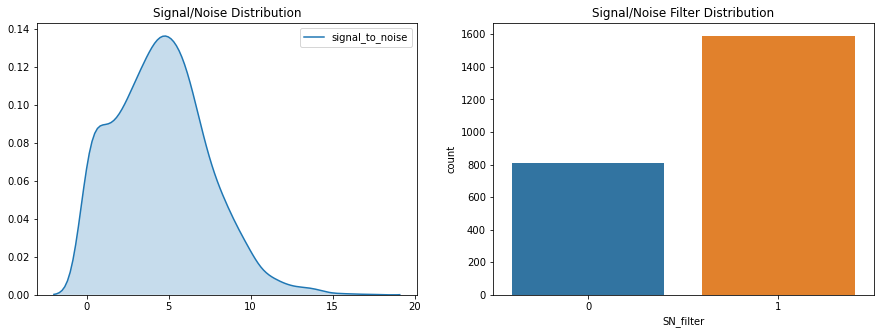

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(train['signal_to_noise'], shade=True, ax=ax[0])
sns.countplot(train['SN_filter'], ax=ax[1])

ax[0].set_title('Signal/Noise Distribution')
ax[1].set_title('Signal/Noise Filter Distribution');

In [9]:
print(f"Samples with signal_to_noise greater than 1: {len(train.loc[(train['signal_to_noise'] > 1 )])}")
print(f"Samples with SN_filter = 1: {len(train.loc[(train['SN_filter'] == 1 )])}")
print(f"Samples with signal_to_noise greater than 1, but SN_filter == 0: {len(train.loc[(train['signal_to_noise'] > 1) & (train['SN_filter'] == 0)])}")

Samples with signal_to_noise greater than 1: 2096
Samples with SN_filter = 1: 1589
Samples with signal_to_noise greater than 1, but SN_filter == 0: 509


**Update: as per [this discussion post](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183992), both public *and* private test datasets are now filtered with the same 3 above conditions.**

# Feature Engineering

**Check out [Tito](https://www.kaggle.com/its7171)'s kernel [here](https://www.kaggle.com/its7171/gru-lstm-with-feature-engineering-and-augmentation) for the feature engineering code below. The `bpps` folder contains Base Pairing Probabilities matrices for each sequence. These matrices give the probability that each pair of nucleotides in the RNA forms a base pair. Each matrix is a symmetric square matrix the same length as the sequence. For a complete EDA of the `bpps` folder, see this notebook [here](https://www.kaggle.com/hidehisaarai1213/openvaccine-checkout-bpps?scriptVersionId=42460013).**

In [10]:
def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").sum(axis=1))
    return bpps_arr

def read_bpps_max(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy").max(axis=1))
    return bpps_arr

def read_bpps_nb(df):
    #mean and std from https://www.kaggle.com/symyksr/openvaccine-deepergcn 
    bpps_nb_mean = 0.077522
    bpps_nb_std = 0.08914
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps = np.load(f"../input/stanford-covid-vaccine/bpps/{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        bpps_arr.append(bpps_nb)
    return bpps_arr 

train['bpps_sum'] = read_bpps_sum(train)
test['bpps_sum'] = read_bpps_sum(test)
train['bpps_max'] = read_bpps_max(train)
test['bpps_max'] = read_bpps_max(test)
train['bpps_nb'] = read_bpps_nb(train)
test['bpps_nb'] = read_bpps_nb(test)

#sanity check
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,bpps_sum,bpps_max,bpps_nb
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...","[0.19854229, 0.18371220000000002, 0.0600024000...","[0.0217857, 0.0386527, 0.0275904, 0.00947066, ...","[2.0659663786252436, 1.2272143577570933, -0.34..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,"[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.16883627604054915, 0.10675940059456464, 0.0...","[0.11931483477784201, 0.0808186531761711, 0.06...","[0.49330633949746183, 0.49330633949746183, -0...."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499...","[0.06680724164624499, 0.04433748694733778, 0.0...","[0.017340043515196805, 0.00826566577930985, 0....","[2.275654383842281, 2.5901863916678374, 0.8078..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,"[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.22702912000000003, 0.18439387000000002, 0.0...","[0.0350158, 0.0332295, 0.00272567, 0.0, 0.0, 0...","[0.5981503421059805, 0.9126823499315369, -0.65..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,"[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,...","[0.04036075455181073, 0.08021642791992274, 0.0...","[0.02230060114516417, 0.052274223411953764, 0....","[0.5981503421059805, 0.807838347323

**Let's explore these newly engineered features to see if they can be trusted (i.e., are their distributions similar across the training set and the two testing sets?)**

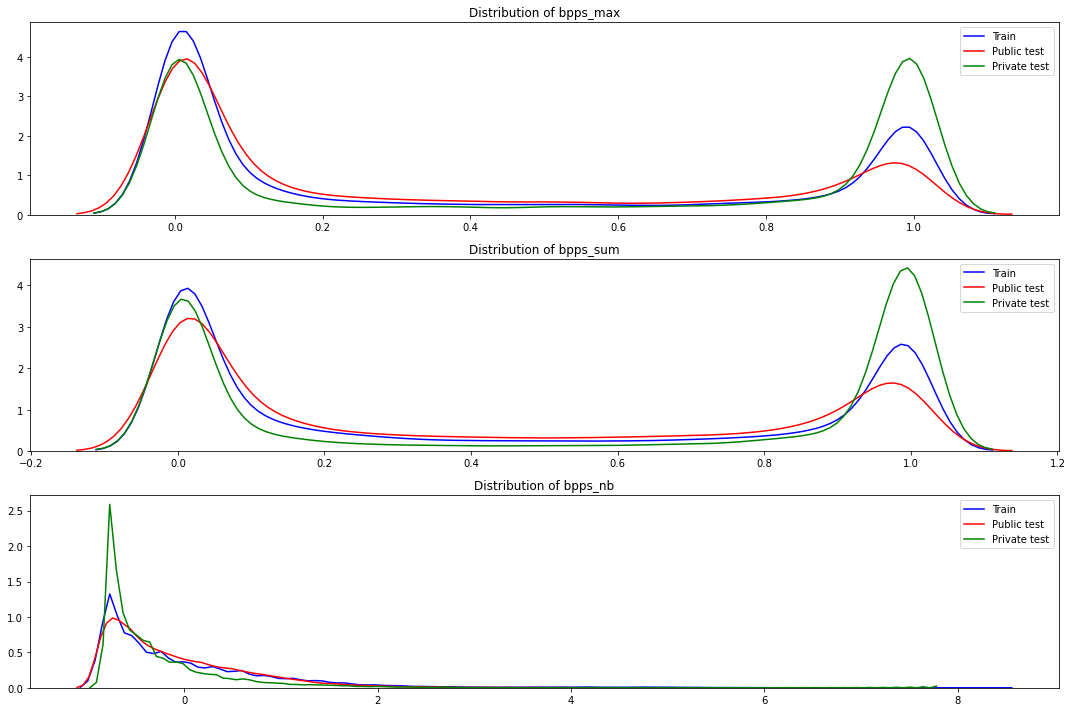

In [11]:
fig, ax = plt.subplots(3, figsize=(15, 10))
sns.kdeplot(np.array(train['bpps_max'].to_list()).reshape(-1),
            color="Blue", ax=ax[0], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_max'].to_list()).reshape(-1),
            color="Red", ax=ax[0], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_max'].to_list()).reshape(-1),
            color="Green", ax=ax[0], label='Private test')
sns.kdeplot(np.array(train['bpps_sum'].to_list()).reshape(-1),
            color="Blue", ax=ax[1], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_sum'].to_list()).reshape(-1),
            color="Red", ax=ax[1], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_sum'].to_list()).reshape(-1),
            color="Green", ax=ax[1], label='Private test')
sns.kdeplot(np.array(train['bpps_nb'].to_list()).reshape(-1),
            color="Blue", ax=ax[2], label='Train')
sns.kdeplot(np.array(test[test['seq_length'] == 107]['bpps_nb'].to_list()).reshape(-1),
            color="Red", ax=ax[2], label='Public test')
sns.kdeplot(np.array(test[test['seq_length'] == 130]['bpps_nb'].to_list()).reshape(-1),
            color="Green", ax=ax[2], label='Private test')

ax[0].set_title('Distribution of bpps_max')
ax[1].set_title('Distribution of bpps_sum')
ax[2].set_title('Distribution of bpps_nb')
plt.tight_layout();

**Looks like `bpps_max` and `bpps_sum` are okay to use, but there is a large difference in the distribution of `bpps_nb` in public vs. private test sets. So even if it improves our LB (or local CV scores), we do not know if it will help with the private test score. For this reason, I will not include it in training.**

# Augmentation

**Augmentation code can be found in [Tito](https://www.kaggle.com/its7171)'s notebook [here](https://www.kaggle.com/its7171/how-to-generate-augmentation-data). It can be used to generate augmented samples that you can use for training augmentation and test time augmentation (TTA). We are essentially generating new `structures` and `predicted_loop_types` for each `sequence` using the software that was originally used to create them (ARNIE, ViennaRNA, and bpRNA).**

In [12]:
AUGMENT=True

In [13]:
aug_df = pd.read_csv('../input/openvaccineaugmented/aug_data_n2.csv')
print(aug_df.shape)
aug_df.head()

(6034, 7)


,id,sequence,structure,log_gamma,score,cnt,predicted_loop_type
0,id_ffda94f24,GGAAAAACCAAUUGCUAUUAAAGGUUCCUUUGUUCGCUAAGUCCAA...,.......(((..((((..(.(((((.(((((((...((..(((((....,1,0.861356,4,EEEEEEESSSIISSSSBBSBSSSSSBSSSSSSSIIISSIISSSSSH...
1,id_0d893f433,GGAAAUUGGCCAUCGUAACGGCGUGUGCAGGAGCUACGAACCUCUG...,................(((.(((((.((..((((.....(((((.(...,0,0.856460,5,EEEEEEEEEEEEEEEESSSISSSSSBSSIISSSSBBBBBSSSSSBS...
2,id_0d9d2e775,GGAAACAACACGAGAACAGUGAUGACACAAGUACCUACGGUUACGU...,.....(((((((((..((((((((.(.((((((((((((....)))...,0,0.993848,4,EEEEESSSSSSSSSIISSSSSSSSBSBSSSSSSSSSSSSHHHHSSS...
3,id_0da46ead4,GGAAACGCCGCCGGCCGGCCUGCCAGCAGCGCGGUAUGCCUGCAUA...,(....)..((((((.(((.(((...(..(((((.((((....))))...,2,0.897231,3,SHHHHSXXSSSSSSISSSISSSMMMSBBSSSSSISSSSHHHHSSSS...
4,id_0da624e95,GGAAACGUCCGCGAUCUUUGCCAACCCGCAACUCUACAUGAUCGGA...,(((....)))....(((((((......)))(((((...(((..(((...,1,0.862958,5,SSSHHHHSSSXXXXSSSSSSSHHHHHHSSSSSSSSBBBSSSBBSSS...


In [14]:
def aug_data(df):
    target_df = df.copy()
    new_df = aug_df[aug_df['id'].isin(target_df['id'])]
                         
    del target_df['structure']
    del target_df['predicted_loop_type']
    new_df = new_df.merge(target_df, on=['id','sequence'], how='left')

    df['cnt'] = df['id'].map(new_df[['id','cnt']].set_index('id').to_dict()['cnt'])
    df['log_gamma'] = 100
    df['score'] = 1.0
    df = df.append(new_df[df.columns])
    return df

In [15]:
print(f"Samples in train before augmentation: {len(train)}")
print(f"Samples in test before augmentation: {len(test)}")

if AUGMENT:
    train = aug_data(train)
    test = aug_data(test)

print(f"Samples in train after augmentation: {len(train)}")
print(f"Samples in test after augmentation: {len(test)}")

print(f"Unique sequences in train: {len(train['sequence'].unique())}")
print(f"Unique sequences in test: {len(test['sequence'].unique())}")

Samples in train before augmentation: 2400
Samples in test before augmentation: 3634
Samples in train after augmentation: 4800
Samples in test after augmentation: 7268
Unique sequences in train: 2400
Unique sequences in test: 3634


# Processing

In [16]:
DENOISE = False

In [17]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [18]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

In [19]:
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    base_fea = np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    bpps_sum_fea = np.array(df['bpps_sum'].to_list())[:,:,np.newaxis]
    bpps_max_fea = np.array(df['bpps_max'].to_list())[:,:,np.newaxis]
    return np.concatenate([base_fea,bpps_sum_fea,bpps_max_fea], 2)

In [20]:
if DENOISE:
    train = train[train['signal_to_noise'] > .25]

# Model

**The below RNN architecture is adapted from the one and only [Xhlulu](https://www.kaggle.com/xhlulu)'s notebook [here](https://www.kaggle.com/xhlulu/openvaccine-simple-gru-model). For his explanation of the model/procedure, see his discussion post [here](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/182303). I have made minor tweaks to some parameters and added an LSTM to experiment with blending.**

**Note that for submission, the output must be the same length as the input, which is 107 for `train.json` and `test.json` and 130 for the private test set. However, this is not true for training, so training prediction sequences only need to be 68 long**

**So we actually build 3 different models: one for training, one for predicting public test, and one for predicting private test set, each with different sequence lengths and prediction lengths. Luckily, we only need to train one model, save its weights, and load these weights into the other models.**

**The last thing to set is the size of the embedding layer. In the context of NLP, the input dimension size of an embedding layer is the size of the vocabulary, which in our case is `len(token2int)`. The output dimension is typically the length of the pre-trained vectors you are using, like the GloVe vectors or Word2Vec vectors, which we don't have in this case, so we are free to experiment with different sizes.**

In [21]:
len(token2int)

14

In [22]:
# https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183211
def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return K.sqrt(mse)

def mcrmse(y_actual, y_pred, num_scored=len(target_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

In [23]:
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

def build_model(rnn='gru', convolve=True, conv_dim=512, 
                dropout=.4, sp_dropout=.2, embed_dim=200,
                hidden_dim=256, layers=3,
                seq_len=107, pred_len=68):
    
###############################################
#### Inputs
###############################################

    inputs = tf.keras.layers.Input(shape=(seq_len, 5))
    categorical_feats = inputs[:, :, :3]
    numerical_feats = inputs[:, :, 3:]

    embed = tf.keras.layers.Embedding(input_dim=len(token2int),
                                      output_dim=embed_dim)(categorical_feats)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = tf.keras.layers.concatenate([reshaped, numerical_feats], axis=2)
    hidden = tf.keras.layers.SpatialDropout1D(sp_dropout)(reshaped)
    
    if convolve:
        hidden = tf.keras.layers.Conv1D(conv_dim, 5, padding='same', activation=tf.keras.activations.swish)(hidden)

###############################################
#### RNN Layers
###############################################

    if rnn is 'gru':
        for _ in range(layers):
            hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    elif rnn is 'lstm':
        for _ in range(layers):
            hidden = lstm_layer(hidden_dim, dropout)(hidden)

###############################################
#### Output
###############################################

    out = hidden[:, :pred_len]
    out = tf.keras.layers.Dense(5, activation='linear')(out)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    adam = tf.optimizers.Adam()
    model.compile(optimizer=adam, loss=mcrmse)

    return model

In [24]:
test_model = build_model(rnn='gru')
test_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 107, 5)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 107, 3)]     0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 107, 3, 200)  2800        tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None, 107, 600)]   0           embedding[0][0]                  
_______________________________________________________________________________________

# KFold Training and Inference

**In previous commits, I either filtered by `SN_filter == 1` or with `signal_to_noise > 1`. But it seems that these RNN models generalize better when exposed to the noisier samples in the dataset. If you review the `tf.keras` [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model), you can see that you can pass a Numpy array of weights during training used to weight the loss function. So we can weight samples with higher `signal_to_noise` values more during training than the noisier samples. As inspired by [Tito](https://www.kaggle.com/its7171), we will pass the following array to `sample_weight`: `np.log1p(train.signal_to_noise + epsilon)/2` where epsilon is a small number to ensure we don't get `log(1)` for any weights.**

**But since the competition hosts have said [here](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/183992), the public and private test sets only contain samples where `SN_filter == 1`, so we ought to validate against the such samples as well:**

In [25]:
def train_and_infer(rnn, STRATIFY=True, FOLDS=4, EPOCHS=50, BATCH_SIZE=64,
                    REPEATS=3, SEED=34, VERBOSE=2):

    #get test now for OOF 
    public_df = test.query("seq_length == 107").copy()
    private_df = test.query("seq_length == 130").copy()
    private_preds = np.zeros((private_df.shape[0], 130, 5))
    public_preds = np.zeros((public_df.shape[0], 107, 5))
    public_inputs = preprocess_inputs(public_df)
    private_inputs = preprocess_inputs(private_df)

    #to evaluate TTA effects/post processing
    holdouts = []
    holdout_preds = []
    
    #to view learning curves
    histories = []
    
    #put similar RNA in the same fold
    gkf = GroupKFold(n_splits=FOLDS)
    kf=KFold(n_splits=FOLDS, random_state=SEED)
    kmeans_model = KMeans(n_clusters=200, random_state=SEED).fit(preprocess_inputs(train)[:,:,0])
    train['cluster_id'] = kmeans_model.labels_

    for _ in range(REPEATS):
        
        for f, (train_index, val_index) in enumerate((gkf if STRATIFY else kf).split(train,
                train['reactivity'], train['cluster_id'] if STRATIFY else None)):

            #define training callbacks
            lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=8, 
                                                               factor=.1,
                                                               #min_lr=1e-5,
                                                               verbose=VERBOSE)
            save = tf.keras.callbacks.ModelCheckpoint(f'model-{f}.h5')

            #define sample weight function
            epsilon = .1
            sample_weighting = np.log1p(train.iloc[train_index]['signal_to_noise'] + epsilon) / 2

            #get train data
            trn = train.iloc[train_index]
            trn_ = preprocess_inputs(trn)
            trn_labs = np.array(trn[target_cols].values.tolist()).transpose((0, 2, 1))

            #get validation data
            val = train.iloc[val_index]
            val_all = preprocess_inputs(val)
            val = val[val.SN_filter == 1]
            val_ = preprocess_inputs(val)
            val_labs = np.array(val[target_cols].values.tolist()).transpose((0, 2, 1))

            #pre-build models for different sequence lengths
            model = build_model(rnn=rnn)
            model_short = build_model(rnn=rnn,seq_len=107, pred_len=107)
            model_long = build_model(rnn=rnn,seq_len=130, pred_len=130)

            #train model
            history = model.fit(
                trn_, trn_labs,
                validation_data = (val_, val_labs),
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                sample_weight=sample_weighting,
                callbacks=[save, lr_callback],
                verbose=VERBOSE
            )

            histories.append(history)

            #load best models
            model.load_weights(f'model-{f}.h5')
            model_short.load_weights(f'model-{f}.h5')
            model_long.load_weights(f'model-{f}.h5')

            holdouts.append(train.iloc[val_index])
            holdout_preds.append(model.predict(val_all))

            public_preds += model_short.predict(public_inputs) / (FOLDS * REPEATS)
            private_preds += model_long.predict(private_inputs) / (FOLDS * REPEATS)
        
        del model, model_short, model_long
        
    return holdouts, holdout_preds, public_df, public_preds, private_df, private_preds, histories

### GRU & LSTM

In [26]:
gru_holdouts, gru_holdout_preds, public_df, gru_public_preds, private_df, gru_private_preds, gru_histories = train_and_infer(rnn='gru')

Epoch 1/50
57/57 - 8s - loss: 0.3390 - val_loss: 0.3463
Epoch 2/50
57/57 - 6s - loss: 0.2766 - val_loss: 0.3194
Epoch 3/50
57/57 - 6s - loss: 0.2630 - val_loss: 0.3076
Epoch 4/50
57/57 - 6s - loss: 0.2532 - val_loss: 0.3084
Epoch 5/50
57/57 - 6s - loss: 0.2444 - val_loss: 0.2867
Epoch 6/50
57/57 - 6s - loss: 0.2317 - val_loss: 0.2739
Epoch 7/50
57/57 - 6s - loss: 0.2224 - val_loss: 0.2691
Epoch 8/50
57/57 - 6s - loss: 0.2136 - val_loss: 0.2616
Epoch 9/50
57/57 - 6s - loss: 0.2040 - val_loss: 0.2585
Epoch 10/50
57/57 - 6s - loss: 0.1984 - val_loss: 0.2576
Epoch 11/50
57/57 - 6s - loss: 0.1936 - val_loss: 0.2483
Epoch 12/50
57/57 - 6s - loss: 0.1889 - val_loss: 0.2540
Epoch 13/50
57/57 - 6s - loss: 0.1841 - val_loss: 0.2508
Epoch 14/50
57/57 - 6s - loss: 0.1800 - val_loss: 0.2471
Epoch 15/50
57/57 - 6s - loss: 0.1767 - val_loss: 0.2454
Epoch 16/50
57/57 - 6s - loss: 0.1728 - val_loss: 0.2446
Epoch 17/50
57/57 - 6s - loss: 0.1696 - val_loss: 0.2462
Epoch 18/50
57/57 - 6s - loss: 0.1663 - 

In [27]:
lstm_holdouts, lstm_holdout_preds, public_df, lstm_public_preds, private_df, lstm_private_preds, lstm_histories = train_and_infer(rnn='gru')

Epoch 1/50
57/57 - 7s - loss: 0.3262 - val_loss: 0.3449
Epoch 2/50
57/57 - 6s - loss: 0.2750 - val_loss: 0.3190
Epoch 3/50
57/57 - 6s - loss: 0.2621 - val_loss: 0.3062
Epoch 4/50
57/57 - 6s - loss: 0.2501 - val_loss: 0.2950
Epoch 5/50
57/57 - 6s - loss: 0.2383 - val_loss: 0.2793
Epoch 6/50
57/57 - 6s - loss: 0.2273 - val_loss: 0.2736
Epoch 7/50
57/57 - 6s - loss: 0.2187 - val_loss: 0.2611
Epoch 8/50
57/57 - 6s - loss: 0.2102 - val_loss: 0.2593
Epoch 9/50
57/57 - 6s - loss: 0.2013 - val_loss: 0.2625
Epoch 10/50
57/57 - 6s - loss: 0.1960 - val_loss: 0.2524
Epoch 11/50
57/57 - 6s - loss: 0.1901 - val_loss: 0.2509
Epoch 12/50
57/57 - 6s - loss: 0.1851 - val_loss: 0.2542
Epoch 13/50
57/57 - 6s - loss: 0.1809 - val_loss: 0.2628
Epoch 14/50
57/57 - 6s - loss: 0.1771 - val_loss: 0.2503
Epoch 15/50
57/57 - 6s - loss: 0.1726 - val_loss: 0.2481
Epoch 16/50
57/57 - 6s - loss: 0.1697 - val_loss: 0.2464
Epoch 17/50
57/57 - 6s - loss: 0.1665 - val_loss: 0.2481
Epoch 18/50
57/57 - 6s - loss: 0.1636 - 

### Learning Curves and Evaluation

In [28]:
def plot_learning_curves(results):

    fig, ax = plt.subplots(1, len(results['histories']), figsize = (20, 10))
    
    for i, result in enumerate(results['histories']):
        for history in result:
            ax[i].plot(history.history['loss'], color='C0')
            ax[i].plot(history.history['val_loss'], color='C1')
            ax[i].set_title(f"{results['models'][i]}")
            ax[i].set_ylabel('MCRMSE')
            ax[i].set_xlabel('Epoch')
            ax[i].legend(['train', 'validation'], loc = 'upper right')
            
results = {
            "models" : ['GRU', 'LSTM'],    
            "histories" : [gru_histories, lstm_histories],
            }

In [29]:
#https://www.kaggle.com/xhlulu/openvaccine-simple-gru-model
def format_predictions(test_df, test_preds, val=False):
    preds = []
    
    for df, preds_ in zip(test_df, test_preds):
        for i, uid in enumerate(df['id']):
            single_pred = preds_[i]

            single_df = pd.DataFrame(single_pred, columns=target_cols)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            if val: single_df['SN_filter'] = df[df['id'] == uid].SN_filter.values[0]

            preds.append(single_df)
    return pd.concat(preds).groupby('id_seqpos').mean().reset_index() if AUGMENT else pd.concat(preds)

In [30]:
def get_error(preds):
    val = pd.read_json('../input/stanford-covid-vaccine/train.json', lines=True)

    val_data = []
    for mol_id in val['id'].unique():
        sample_data = val.loc[val['id'] == mol_id]
        sample_seq_length = sample_data.seq_length.values[0]
        for i in range(68):
            sample_dict = {
                           'id_seqpos' : sample_data['id'].values[0] + '_' + str(i),
                           'reactivity_gt' : sample_data['reactivity'].values[0][i],
                           'deg_Mg_pH10_gt' : sample_data['deg_Mg_pH10'].values[0][i],
                           'deg_Mg_50C_gt' : sample_data['deg_Mg_50C'].values[0][i],
                           }
            
            val_data.append(sample_dict)
            
    val_data = pd.DataFrame(val_data)
    val_data = val_data.merge(preds, on='id_seqpos')

    rmses = []
    mses = []
    
    for col in ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']:
        rmse = ((val_data[col] - val_data[col+'_gt']) ** 2).mean() ** .5
        mse = ((val_data[col] - val_data[col+'_gt']) ** 2).mean()
        rmses.append(rmse)
        mses.append(mse)
        print(col, rmse, mse)
    print(np.mean(rmses), np.mean(mses))
    print('')

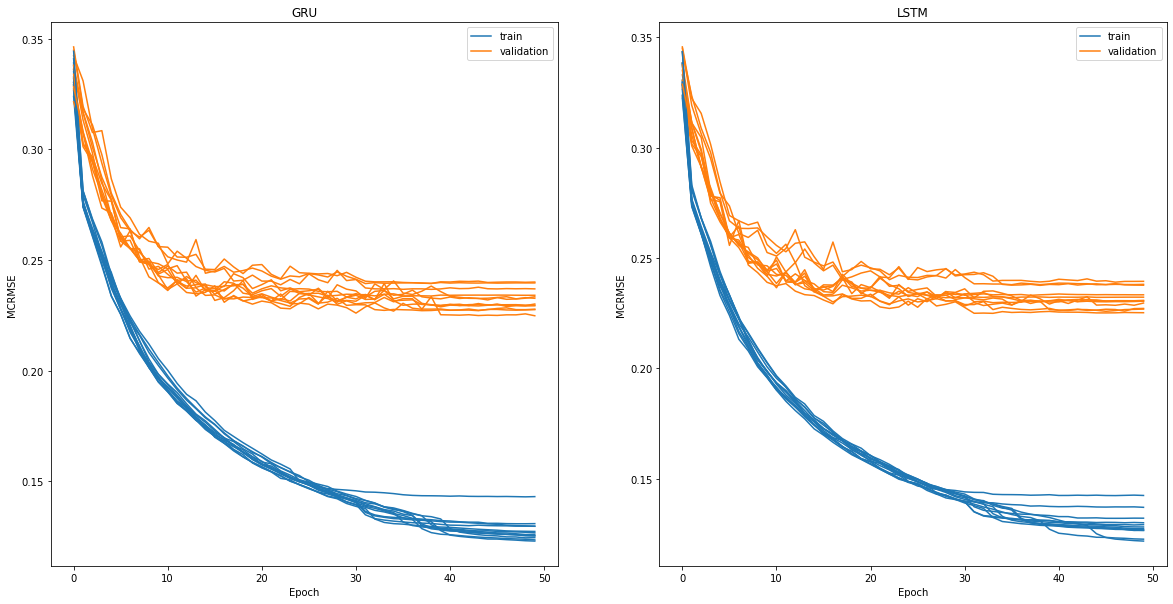

In [31]:
plot_learning_curves(results)

In [32]:
gru_val_preds = format_predictions(gru_holdouts, gru_holdout_preds, val=True)
lstm_val_preds = format_predictions(lstm_holdouts, lstm_holdout_preds, val=True)

print('-'*25); print('Unfiltered training results'); print('-'*25)
print('GRU training results'); print('')
get_error(gru_val_preds)
print('LSTM training results'); print('')
get_error(lstm_val_preds)
print('-'*25); print('SN_filter == 1 training results'); print('-'*25)
print('GRU training results'); print('')
get_error(gru_val_preds[gru_val_preds['SN_filter'] == 1])
print('LSTM training results'); print('')
get_error(lstm_val_preds[lstm_val_preds['SN_filter'] == 1])

-------------------------
Unfiltered training results
-------------------------
GRU training results

reactivity 0.6200154828588159 0.38441919898465066
deg_Mg_pH10 0.5646792633514699 0.3188626704591587
deg_Mg_50C 0.7543595905422803 0.5690583918431168
0.6463514455841888 0.4241134204289754

LSTM training results

reactivity 0.6208846252030212 0.3854977178134961
deg_Mg_pH10 0.5642080860753369 0.3183307643927948
deg_Mg_50C 0.754273657212264 0.5689287499643639
0.6464554561635407 0.42425241072355163

-------------------------
SN_filter == 1 training results
-------------------------
GRU training results

reactivity 0.22243559278432087 0.04947759293731222
deg_Mg_pH10 0.27480544365673365 0.07551803186337422
deg_Mg_50C 0.22749065724772097 0.05175199913500006
0.24157723122959185 0.05891587464522883

LSTM training results

reactivity 0.22200121747613605 0.04928454056088666
deg_Mg_pH10 0.27379961864075353 0.07496623116782206
deg_Mg_50C 0.22689893510122927 0.05148312675007185
0.24089992373937297 0.

# Submission

In [33]:
gru_preds = [gru_public_preds, gru_private_preds]
lstm_preds = [gru_public_preds, gru_private_preds]
test_df = [public_df, private_df]
gru_preds = format_predictions(test_df, gru_preds)
lstm_preds = format_predictions(test_df, lstm_preds)

In [34]:
gru_weight = .5
lstm_weight = .5

In [35]:
blended_preds = pd.DataFrame()
blended_preds['id_seqpos'] = gru_preds['id_seqpos']
blended_preds['reactivity'] = gru_weight*gru_preds['reactivity'] + lstm_weight*lstm_preds['reactivity']
blended_preds['deg_Mg_pH10'] = gru_weight*gru_preds['deg_Mg_pH10'] + lstm_weight*lstm_preds['deg_Mg_pH10']
blended_preds['deg_pH10'] = gru_weight*gru_preds['deg_pH10'] + lstm_weight*lstm_preds['deg_pH10']
blended_preds['deg_Mg_50C'] = gru_weight*gru_preds['deg_Mg_50C'] + lstm_weight*lstm_preds['deg_Mg_50C']
blended_preds['deg_50C'] = gru_weight*gru_preds['deg_50C'] + lstm_weight*lstm_preds['deg_50C']

In [36]:
submission = sample_sub[['id_seqpos']].merge(blended_preds, on=['id_seqpos'])
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.787052,0.677450,1.952556,0.550615,0.812082
1,id_00073f8be_1,2.408981,3.392284,4.258829,3.331823,2.933508
2,id_00073f8be_2,1.653061,0.639064,0.688601,0.739491,0.672309
3,id_00073f8be_3,1.316790,1.131847,1.197031,1.626872,1.845242
4,id_00073f8be_4,0.812740,0.573058,0.500574,0.848505,0.854665


In [37]:
submission.to_csv(f'submission_new.csv', index=False)
print('Submission saved')

Submission saved
